In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()
import numpy as np
import bokeh as bk

In [284]:
# Cleanup and basic data prep
dat = pd.read_csv("seattle_incidents_summer_2014.csv", parse_dates=True)
# To do analysis in aggregate, working with 'Occured Date'
dat['date']= pd.to_datetime(dat[u'Occurred Date or Date Range Start'])
dat = dat.set_index('date')
# With pandas, in general
dat=dat.sort_index()

dat['week']=dat.index.week

# Start of basic analysis

I'm starting with a basic question : how does crime vary with time in our Seattle dataset? My conclusions were simple:
* There is no obvious overall trend over the period that we're considering (June-Sept 2014) in overall crime, or in the top major categories (by proportion)
* Overall crime increases on Fridays, and decreases on Sundays
* Assaults and burglaries exhibit clear negative correlation. In other words, on the weekends assaults go up and burglaries go down. This is expected, though somewhat perverse: people are home on the weekends, so burglaries are more risky(arguably). Also, on the weekends, people are likely to have more direct social contact which could explan an uptick in fights.


So, before we try anything more complex, I aggreate events by day (depicted by the dotted line), counting every row as an event. This is crude, but it shows a substantial amount of daily variability in the data, ranging between 250 and 450 'events' per day. To aid reading the chart I'm also looking at a simple rolling average over a 15-day window (depicted with the solid line). This shows that overall crime doesn't appear to strongly trend up or down in this period. 

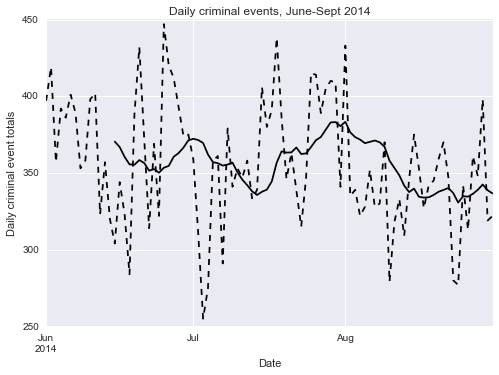

In [290]:
dat['week']=dat.index.week
s = dat[u'week'].resample('d','count')
s.plot(style='k--')
r = pd.rolling_mean(s, window=15)
r.plot(style='k')
plt.ylabel('Daily criminal event totals')
plt.title('Daily criminal events, June-Sept 2014')
plt.xlabel('Date')

# Some summary statistics for 'daily' data.
This serves to confirm the visual impression from the prior graphic

In [119]:
dat[u'week'].resample('d','count').describe()

count     92.000000
mean     356.293478
std       40.590027
min      255.000000
25%      328.000000
50%      353.000000
75%      388.250000
max      447.000000
Name: week, dtype: float64

# Weekly statistics (overlay of days of weeks)

First, I'm interested if certain days of the week are more associated with crime 'events'. Later, I'll look at different types of events. To investigate this, I need to put each week in a column, and index by the days of the week. It's worth keeping in mind that I'm only operating on 92 days worth of data, or ~13 weeks. The following chart overlays the series for each week with a different color.

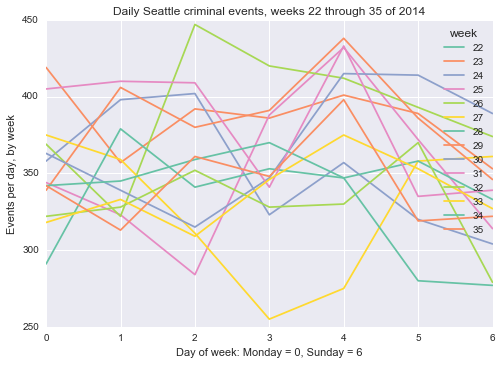

In [291]:
week_day_index = pd.MultiIndex.from_tuples(zip(s.index.week, s.index.dayofweek), names=['week', 'day'])
# s.reindex(day_week_index)
#s.reindex(week_day_index)
dat_wd = pd.Series(s.get_values(), index=week_day_index)

dat_wd.unstack('week').plot()
plt.ylabel('Events per day, by week')
plt.xlabel('Day of week: Monday = 0, Sunday = 6')
plt.title('Daily Seattle criminal events, weeks 22 through 35 of 2014')

## Refinement
So... the above wasn't very clear. To check if there is any daily trend, I'm going to take the daily mean, and visualize the spread of this daily estimator with 700 bootstrap samples. This reveals that there is a trend! Basically, Friday has a spike and Sunday has a dip relative to the daily average events. Who knew that criminals rested on Sunday?

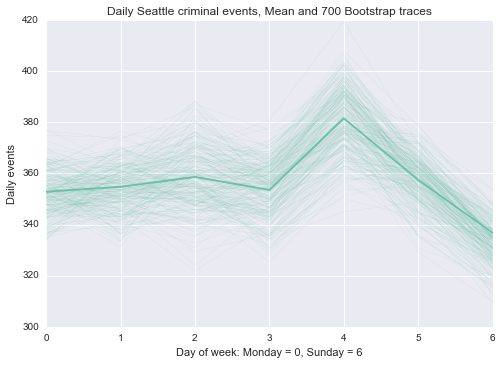

In [292]:
# Plot the average over replicates with bootstrap resamples
sns.set(style="darkgrid", palette="Set2")
sns.tsplot(dat_wd.unstack('day').values, err_style="boot_traces", n_boot=700)
sns.tsplot(dat_wd.unstack('day').mean())
plt.ylabel('Daily events')
plt.xlabel('Day of week: Monday = 0, Sunday = 6')
plt.title('Daily Seattle criminal events, Mean and 700 Bootstrap traces')

# Types of crime
Do the above patterns hold with different categories of offenses?

## Major types of crime

Tabulating events by the 'Summarized Offense Description', the top 4 were (with relative frequency in the overall dataset):
* Car prowl - %19
* Other property (not sure what - %11.4
* Vehicle theft - %9
* Burglary - %9

(I didn't include the code/chart in this workbook because it's already long enough)
Basically, crimes are predominantly nonviolent. Looking further down the list, the first violent crime category was assault (at %6 of total events). I'm curious how violent crime with compare to non-violent crime so I'll consider Burglary and Assault later.

First, I'm looking at the range of the entire period. This is identical to my first chart, except that I'm adding subfigures that correspond to the above 5 groups. As a reminder, I'm taking daily events (depicted by the dotted line), and over laying a simple rolling average over a 15-day window (depicted by the solid line). The variability of these events is much lower than the aggregate chart, and, like the aggregate, there doesn't appear to be any discernable trend.

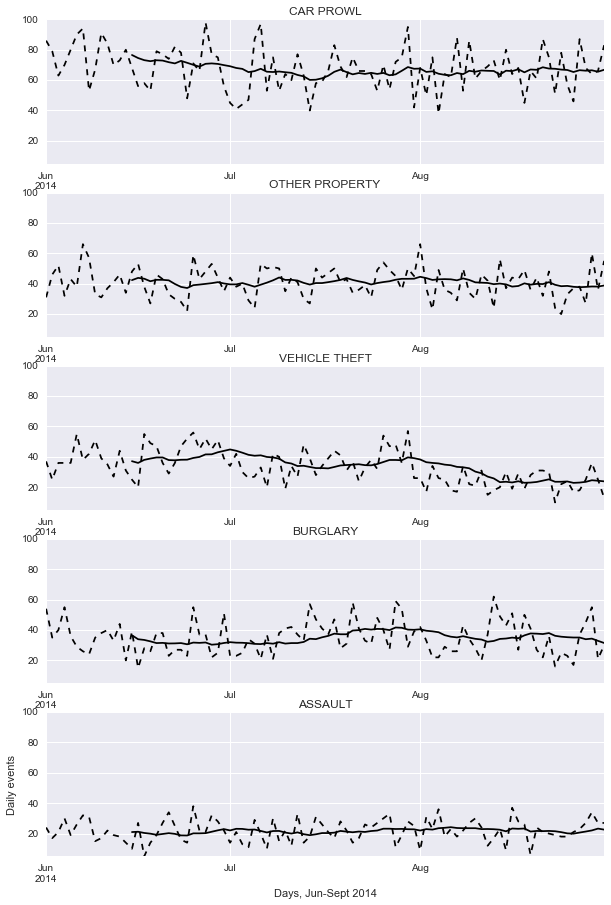

In [259]:
fig, axs = plt.subplots(5,1, figsize=(10, 15))

axis = 0
for cat in ['CAR PROWL', 'OTHER PROPERTY', 'VEHICLE THEFT', 'BURGLARY', 'ASSAULT'] :
    s = groups.get_group(cat)[u'week'].resample('d','count')
    s.plot(ax=axs[axis], style='k--')
    r = pd.rolling_mean(s, window=15)
    r.plot(ax=axs[axis], style='k')
    axs[axis].set_title(cat)
    axs[axis].set_ylim([5, 100])
    axis += 1
    plt.ylabel('Daily events')
    
plt.xlabel('Days, Jun-Sept 2014') 

## Weekly Statistics, Assaults vs. Burglaries
My final chart is a quick trend comparison of assaults and burglaries. I chose these two categories becuase they represent violent and non-violent crime, and are of a similar magnitude so they can reasonably be plotted on the same axis without needing to normalize them. This analysis is identical to my daily trend analysis above -  I'm taking the daily mean of burglaries and robberies, and visualizing the spread of this daily estimator with 700 bootstrap samples. 

I love this chart. It clearly shows that assaults and burglaries exhibit clear negative correlation. In other words, on the weekends assaults go up and burglaries go down. This is expected, though somewhat perverse: people are home on the weekends, so burglaries are more risky(arguably). Also, on the weekends, people are likely to have more direct social contact which could explan an uptick in fights.

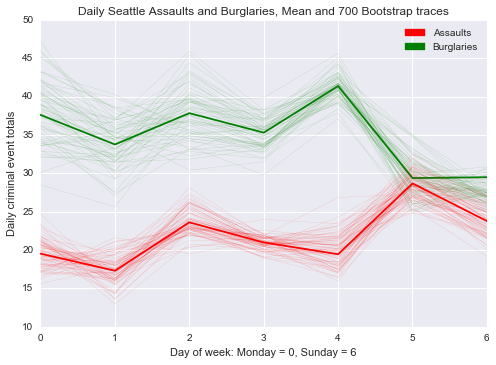

In [295]:
  
s = groups.get_group('BURGLARY')[u'week'].resample('d','count')
week_day_index = pd.MultiIndex.from_tuples(zip(s.index.week, s.index.dayofweek), names=['week', 'day'])
dat_wd = pd.Series(s.get_values(), index=week_day_index)
sns.tsplot(dat_wd.unstack('day').values, err_style="boot_traces", n_boot=200, color="g")
sns.tsplot(dat_wd.unstack('day').mean(), color="g")

s = groups.get_group('ASSAULT')[u'week'].resample('d','count')
week_day_index = pd.MultiIndex.from_tuples(zip(s.index.week, s.index.dayofweek), names=['week', 'day'])
dat_wd = pd.Series(s.get_values(), index=week_day_index)
sns.tsplot(dat_wd.unstack('day').values, err_style="boot_traces", n_boot=200, color="r")
sns.tsplot(dat_wd.unstack('day').mean(), color="r")

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Assaults')
green_patch =  mpatches.Patch(color='green', label='Burglaries')
plt.legend(handles=[red_patch, green_patch])
# plt.xlabel('Days (Monday = 0, Sunday = 6), Jun-Sept 2014')
plt.title('Daily Seattle Assaults and Burglaries, Mean and 700 Bootstrap traces')
plt.ylabel('Daily criminal event totals')
# plt.title('Daily criminal events, June-Sept 2014')
plt.xlabel('Day of week: Monday = 0, Sunday = 6')
plt.show()


